In [ ]:
!pip install pennylane torch torchvision torchaudio


In [ ]:
!pip install -q isic-cli
!isic user login


Hello solari93por21@gmail.com!


In [ ]:
#This code was built by muhannad alkwiefati
# 1) Install isic-cli
!pip install -q isic-cli

# 2) Login
!isic user login

# ===============================
# 3) Download Challenge 2019 Training (Collection 65)
!mkdir -p data2019/all/healthy data2019/all/malignant
!isic image download --collections 65 --search 'diagnosis_1:"Benign"'    --limit 5000 data2019/all/healthy
!isic image download --collections 65 --search 'diagnosis_1:"Malignant"' --limit 5000 data2019/all/malignant


Hello solari93por21@gmail.com!

Successfully downloaded 5,000 images to data2019/all/healthy/.
Successfully wrote 5,000 metadata records to data2019/all/healthy/metadata.csv.
Successfully wrote attributions to data2019/all/healthy/attribution.txt.
Successfully wrote 2 license(s) to data2019/all/healthy/licenses.

Successfully downloaded 5,000 images to data2019/all/malignant/.
Successfully wrote 5,000 metadata records to data2019/all/malignant/metadata.csv.
Successfully wrote attributions to data2019/all/malignant/attribution.txt.
Successfully wrote 2 license(s) to data2019/all/malignant/licenses.


 Deleted 0 duplicate images
Balancing dataset → 5000 per class
healthy: 4000 train, 500 val, 500 test
malignant: 4000 train, 500 val, 500 test
train/healthy : 4000
train/malignant : 4000
val/healthy : 500
val/malignant : 500
test/healthy : 500
test/malignant : 500


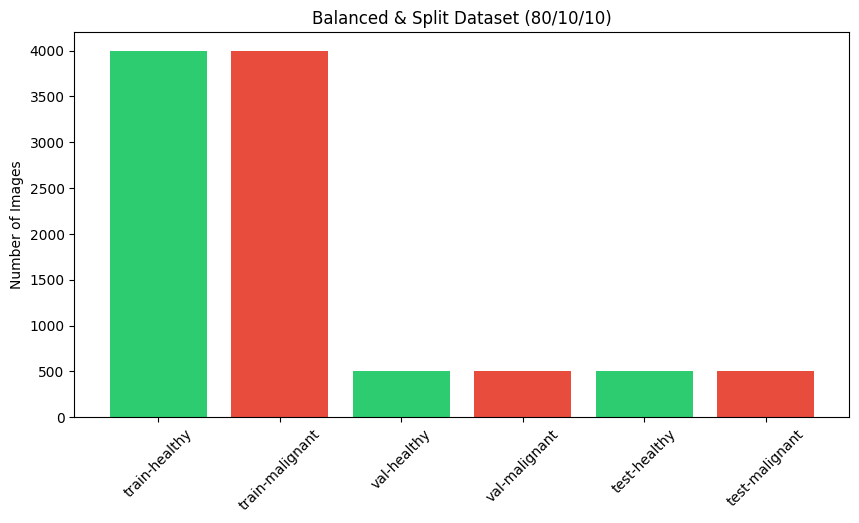

In [ ]:
#This code was built by muhannad alkwiefati

import pathlib, hashlib, os, random, shutil, matplotlib.pyplot as plt
random.seed(42)

base = pathlib.Path("data2019")

# =============== 1) Remove duplicates ===============
def file_hash(path, algo="md5", chunk_size=8192):
    h = hashlib.new(algo)
    with open(path, "rb") as f:
        while chunk := f.read(chunk_size):
            h.update(chunk)
    return h.hexdigest()

def remove_duplicates(root="data2019/all"):
    root = pathlib.Path(root)
    hashes, deleted = {}, 0
    for img_path in root.rglob("*.jpg"):
        h = file_hash(img_path)
        if h in hashes:
            os.remove(img_path)
            deleted += 1
        else:
            hashes[h] = img_path
    print(f" Deleted {deleted} duplicate images")

remove_duplicates()

#2) Balance dataset before splitting
def balance_classes():
    h_imgs = list((base/"all"/"healthy").glob("*.jpg"))
    m_imgs = list((base/"all"/"malignant").glob("*.jpg"))

    target = min(len(h_imgs), len(m_imgs))  # equalize to smaller class
    print(f"Balancing dataset → {target} per class")

    for cls, imgs in [("healthy", h_imgs), ("malignant", m_imgs)]:
        if len(imgs) > target:
            to_remove = random.sample(imgs, len(imgs)-target)
            for f in to_remove: os.remove(f)

balance_classes()

#3) Clean old splits
for split in ["train","val","test"]:
    for cls in ["healthy","malignant"]:
        folder = base/split/cls
        if folder.exists():
            shutil.rmtree(folder)

# =============== 4) Split 80/10/10 ===============
def split_dataset(cls, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    all_imgs = list((base/"all"/cls).glob("*.jpg"))
    random.shuffle(all_imgs)

    n_total = len(all_imgs)
    n_train = int(n_total * train_ratio)
    n_val   = int(n_total * val_ratio)
    n_test  = n_total - n_train - n_val

    splits = {
        "train": all_imgs[:n_train],
        "val"  : all_imgs[n_train:n_train+n_val],
        "test" : all_imgs[n_train+n_val:]
    }

    for split, imgs in splits.items():
        outdir = base/split/cls
        outdir.mkdir(parents=True, exist_ok=True)
        for img in imgs:
            shutil.copy(str(img), str(outdir/img.name))

    print(f"{cls}: {n_train} train, {n_val} val, {n_test} test")

split_dataset("healthy")
split_dataset("malignant")

# =============== 5) Show final counts + plot ===============
counts = {}
for split in ["train","val","test"]:
    counts[split] = {}
    for cls in ["healthy","malignant"]:
        folder = base/split/cls
        count = len(list(folder.glob("*.jpg")))
        counts[split][cls] = count
        print(f"{split}/{cls} : {count}")

labels, values = [], []
for split in counts:
    for cls in counts[split]:
        labels.append(f"{split}-{cls}")
        values.append(counts[split][cls])

plt.figure(figsize=(10,5))
plt.bar(labels, values, color=["#2ecc71","#e74c3c"]*3)
plt.title("Balanced & Split Dataset (80/10/10)")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets.folder import default_loader
import pathlib
from collections import Counter

# Simple dataset class
class SimpleImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
        self.loader = default_loader
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, y = self.samples[idx]
        img = self.loader(path)
        if self.transform:
            img = self.transform(img)
        return img, y

def make_loaders(base="data2019", image_size=128, batch_size=32, seed=42):
    base = pathlib.Path(base)
    #   [-1,1]ImageNet
    mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]

    # Train transforms with augmentations
    tf_train = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Eval transforms (val/test)
    tf_eval = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Helper to gather samples
    def gather(split, cls, label):
        folder = base/f"{split}/{cls}"
        return [(str(p), label) for p in folder.glob("*.jpg")]

    # Gather all samples
    samples_train = gather("train","healthy",0) + gather("train","malignant",1)
    samples_val   = gather("val","healthy",0)   + gather("val","malignant",1)
    samples_test  = gather("test","healthy",0)  + gather("test","malignant",1)

    # Datasets
    ds_train = SimpleImageDataset(samples_train, transform=tf_train)
    ds_val   = SimpleImageDataset(samples_val, transform=tf_eval)
    ds_test  = SimpleImageDataset(samples_test, transform=tf_eval)

    # DataLoaders
    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Info
    print("DataLoaders ready.")
    print("Train samples:", len(ds_train), "| Val:", len(ds_val), "| Test:", len(ds_test))
    print("Class dist (train):", Counter([y for _,y in ds_train.samples]))

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = make_loaders(image_size=128, batch_size=32)


DataLoaders ready.
Train samples: 8000 | Val: 1000 | Test: 1000
Class dist (train): Counter({0: 4000, 1: 4000})


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import pennylane as qml

# Quantum settings
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class HQCNNLayer(nn.Module):
    def __init__(self, in_features, n_qubits=4, n_layers=2):
        super().__init__()
        self.n_qubits = n_qubits
        self.weight_shapes = {"weights": (n_layers, n_qubits)}
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, self.weight_shapes)
        self.fc = nn.Linear(in_features, n_qubits)
    def forward(self, x):
        x = self.fc(x)
        return self.q_layer(x)


In [ ]:
class MobileNetBackbone(nn.Module):
    def __init__(self, pretrained=True):
        super(MobileNetBackbone, self).__init__()
        mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1 if pretrained else None)
        self.features = mobilenet.features
        self.out_channels = 1280
    def forward(self, x):
        return self.features(x)


In [ ]:
class HybridSkinCancerNet(nn.Module):
    def __init__(self, num_classes=2, hidden_size=256, num_layers=1):
        super(HybridSkinCancerNet, self).__init__()
        # 1. Backbone CNN
        self.backbone = MobileNetBackbone(pretrained=True)

        # 2. BiLSTM
        self.lstm = nn.LSTM(
            input_size=self.backbone.out_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        # 3. Fully Connected before Quantum
        self.fc1 = nn.Linear(hidden_size*2, 64)
        self.dropout = nn.Dropout(0.3)

        # 4. HQCNN Quantum Layer
        self.hqcnn = HQCNNLayer(64, n_qubits=4, n_layers=2)

        # 5. Output
        self.fc_out = nn.Linear(4, num_classes)

    def forward(self, x):
        # Backbone CNN
        x = self.backbone(x)
        x = F.adaptive_avg_pool2d(x, (1,1))  # [B, 1280, 1, 1]
        x = x.view(x.size(0), 1, -1)         # [B, 1, 1280]

        # BiLSTM
        lstm_out, _ = self.lstm(x)           # [B, 1, hidden*2]
        x = lstm_out[:, -1, :]               # [B, hidden*2]

        # FC + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Quantum layer
        x = self.hqcnn(x)

        # Output
        x = self.fc_out(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridSkinCancerNet(num_classes=2).to(device)
print(model)

HybridSkinCancerNet(
  (backbone): MobileNetBackbone(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96,

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class HybridSkinCancerNet(nn.Module):
    def __init__(self, num_classes=2):
        super(HybridSkinCancerNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*64*64, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



Epoch 1/30


Train: loss=0.6233, acc=0.6903
Val:   loss=0.5911, acc=0.8370
Saved best model

Epoch 2/30


Train: loss=0.5792, acc=0.8421
Val:   loss=0.5422, acc=0.8390
Saved best model

Epoch 3/30


Train: loss=0.5323, acc=0.8494
Val:   loss=0.4984, acc=0.8490
Saved best model

Epoch 4/30


Train: loss=0.4906, acc=0.8616
Val:   loss=0.4703, acc=0.8450
Saved best model

Epoch 5/30


Train: loss=0.4602, acc=0.8652
Val:   loss=0.4336, acc=0.8570
Saved best model

Epoch 6/30


Train: loss=0.4291, acc=0.8750
Val:   loss=0.4104, acc=0.8600
Saved best model

Epoch 7/30


Train: loss=0.4057, acc=0.8742
Val:   loss=0.3892, acc=0.8620
Saved best model

Epoch 8/30


Train: loss=0.3819, acc=0.8801
Val:   loss=0.3575, acc=0.8780
Saved best model

Epoch 9/30


Train: loss=0.3568, acc=0.8912
Val:   loss=0.3700, acc=0.8610
 EarlyStopping counter: 1/5

Epoch 10/30


Train: loss=0.3300, acc=0.9016
Val:   loss=0.3366, acc=0.8850
Saved best model

Epoch 11/30


Train: loss=0.3183, acc=0.8972
Val:   loss=0.3509, acc=0.8660
 EarlyStopping counter: 1/5

Epoch 12/30


Train: loss=0.2977, acc=0.9080
Val:   loss=0.3250, acc=0.8660
Saved best model

Epoch 13/30


Train: loss=0.2874, acc=0.9077
Val:   loss=0.3437, acc=0.8700
 EarlyStopping counter: 1/5

Epoch 14/30


Train: loss=0.2683, acc=0.9163
Val:   loss=0.3423, acc=0.8720
 EarlyStopping counter: 2/5

Epoch 15/30


Train: loss=0.2633, acc=0.9160
Val:   loss=0.3259, acc=0.8730
 EarlyStopping counter: 3/5

Epoch 16/30


Train: loss=0.2516, acc=0.9196
Val:   loss=0.3376, acc=0.8660
 EarlyStopping counter: 4/5

Epoch 17/30


Train: loss=0.2214, acc=0.9326
Val:   loss=0.3227, acc=0.8760
Saved best model

Epoch 18/30


Train: loss=0.2060, acc=0.9396
Val:   loss=0.3240, acc=0.8710
 EarlyStopping counter: 1/5

Epoch 19/30


Train: loss=0.1955, acc=0.9444
Val:   loss=0.3146, acc=0.8890
Saved best model

Epoch 20/30


Train: loss=0.1857, acc=0.9454
Val:   loss=0.3037, acc=0.8840
Saved best model

Epoch 21/30


Train: loss=0.1841, acc=0.9465
Val:   loss=0.3174, acc=0.8820
 EarlyStopping counter: 1/5

Epoch 22/30


Train: loss=0.1688, acc=0.9517
Val:   loss=0.3340, acc=0.8760
 EarlyStopping counter: 2/5

Epoch 23/30


Train: loss=0.1636, acc=0.9527
Val:   loss=0.3362, acc=0.8780
 EarlyStopping counter: 3/5

Epoch 24/30


Train: loss=0.1536, acc=0.9579
Val:   loss=0.3204, acc=0.8890
 EarlyStopping counter: 4/5

Epoch 25/30


Train: loss=0.1398, acc=0.9617
Val:   loss=0.3333, acc=0.8860
 EarlyStopping counter: 5/5
 Early stopping triggered!



=== Test Results ===
Loss=0.2712, Acc=0.8970

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.89      0.90      0.90       500
   Malignant       0.90      0.89      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000


Confusion Matrix:
 [[451  49]
 [ 54 446]]


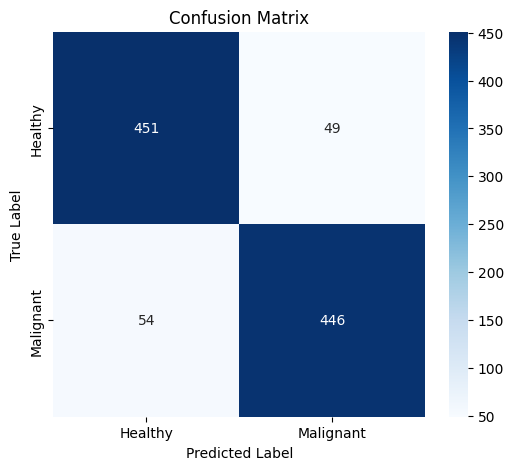

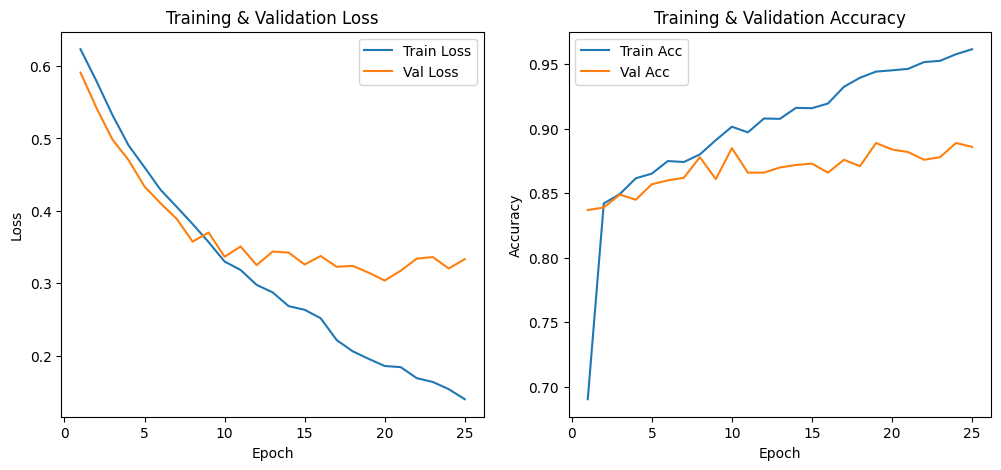

In [ ]:
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# ------------------------------------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in tqdm(loader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        _, preds = outputs.max(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, criterion, device, split="Val"):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []
    for x, y in tqdm(loader, desc=split, leave=False):
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
        running_loss += loss.item() * x.size(0)
        _, preds = outputs.max(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
    return running_loss/total, correct/total, y_true, y_pred

best_val_loss = float("inf")
patience = 5
counter = 0
EPOCHS = 30

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion, device, split="Val")
    scheduler.step(val_loss)

    print(f"Train: loss={tr_loss:.4f}, acc={tr_acc:.4f}")
    print(f"Val:   loss={val_loss:.4f}, acc={val_acc:.4f}")

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_hybrid_model128.pth")
        print("Saved best model")
    else:
        counter += 1
        print(f" EarlyStopping counter: {counter}/{patience}")
        if counter >= patience:
            print(" Early stopping triggered!")
            break

# ------------------------------------------------------
# Final test
model.load_state_dict(torch.load("best_hybrid_model128.pth"))
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion, device, split="Test")
print(f"\n=== Test Results ===")
print(f"Loss={test_loss:.4f}, Acc={test_acc:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Healthy","Malignant"]))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

# ------------------------------------------------------
# Confusion Matrix Plot
cm = confusion_matrix(y_true, y_pred)
classes = ["Healthy", "Malignant"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Plot Training Curves (Loss & Accuracy)
epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs_range, history["train_acc"], label="Train Acc")
plt.plot(epochs_range, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


Saving 24.jpg to 24.jpg


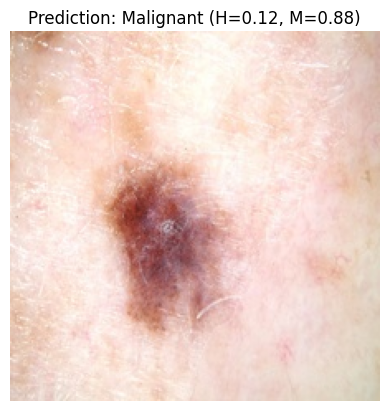

In [ ]:
from google.colab import files
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

image_size = 128
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
tf_eval = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

img = Image.open(img_path).convert("RGB")
x = tf_eval(img).unsqueeze(0).to(device)

model.load_state_dict(torch.load("best_hybrid_model128.pth", map_location=device))
model = model.to(device)
model.eval()

with torch.no_grad():
    outputs = model(x)
    probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
    pred = probs.argmax()

classes = ["Healthy", "Malignant"]
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {classes[pred]} (H={probs[0]:.2f}, M={probs[1]:.2f})")
plt.show()


In [3]:
pip install pennylane


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 133.9 MB/s eta 0:00:00


Saving 54.jpg to 54.jpg


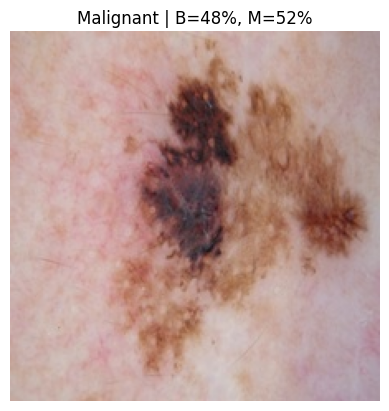

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
class SimpleSkinCancerNet(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleSkinCancerNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*64*64, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class HybridSkinCancerNet(nn.Module):
    def __init__(self, num_classes=2):
        super(HybridSkinCancerNet, self).__init__()
        # CNN part
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.AdaptiveAvgPool2d((8, 8))  # fix output size
        )
        # ResNet feature extractor
        self.resnet = models.resnet18(weights=None)
        self.resnet.fc = nn.Identity()
        # Fusion + classifier
        self.fc = nn.Sequential(
            nn.Linear(64*8*8 + 512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        cnn_feat = self.cnn(x)
        cnn_feat = cnn_feat.view(cnn_feat.size(0), -1)
        resnet_feat = self.resnet(x)
        fused = torch.cat((cnn_feat, resnet_feat), dim=1)
        out = self.fc(fused)
        return out

# Choose model to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridSkinCancerNet(num_classes=2).to(device)
model.load_state_dict(torch.load("best_hybrid_model128.pth", map_location=device), strict=False)
model.eval()

# Prediction pipeline
class_names = ["Benign", "Malignant"]

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert("RGB")
    inp = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(inp)
        probs = torch.softmax(output, dim=1).cpu().numpy()[0]
        pred_idx = output.argmax(dim=1).item()
        pred_class = class_names[pred_idx]

    result_text = f"{pred_class} | B={probs[0]*100:.0f}%, M={probs[1]*100:.0f}%"

    plt.imshow(img)
    plt.title(result_text)
    plt.axis("off")
    plt.show()

